# Fine-tuning BERT for AG News Text Classification

This notebook demonstrates end-to-end fine-tuning of BERT on the AG News dataset.

**Dataset**: AG News (120K training samples, 4 classes)
- Label 0: World
- Label 1: Sports  
- Label 2: Business
- Label 3: Sci/Tech

**Model**: BERT-base-uncased (110M parameters)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1aEY7dEbHs3MwNrtnQ0HUjaewWt-IW4xb#scrollTo=k6NbauvnX2jh" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

</table>

In [ ]:
"""
Google Colab Setup Cell
Add this at the beginning of your notebook
"""

# ============================================
# GOOGLE COLAB SETUP
# ============================================

print("Setting up environment for BERT fine-tuning...")

# 1. Check GPU availability
import torch
print("\n" + "="*50)
print("GPU INFORMATION")
print("="*50)
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: No GPU detected. Training will be slow.")
    print("Enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU")

# 2. Create directory structure
print("\n" + "="*50)
print("CREATING DIRECTORIES")
print("="*50)

import os

directories = [
    '/content/notebooks',
    '/content/reports',
    '/content/output',
    '/content/checkpoints',
    '/content/logs'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ Created: {directory}")

# 3. Install required packages
print("\n" + "="*50)
print("INSTALLING PACKAGES")
print("="*50)
print("This may take 1-2 minutes...\n")

!pip install -q transformers datasets torch accelerate tensorboard scikit-learn

print("✓ All packages installed successfully!")

# 4. Verify installations
print("\n" + "="*50)
print("VERIFYING INSTALLATIONS")
print("="*50)

import transformers
import datasets
import sklearn

print(f"✓ Transformers version: {transformers.__version__}")
print(f"✓ Datasets version: {datasets.__version__}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Scikit-learn version: {sklearn.__version__}")

# 5. Mount Google Drive (optional)
print("\n" + "="*50)
print("GOOGLE DRIVE MOUNT (OPTIONAL)")
print("="*50)

mount_drive = True  # Set to True to mount Google Drive

if mount_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted at /content/drive")
    print("  You can save models to /content/drive/MyDrive/")

    PROJECT_ROOT = '/content/drive/MyDrive/finetuning-bert'

    REPORTS_DIR = f'{PROJECT_ROOT}/reports'
    OUTPUT_DIR = '/content/output'              # fast temp storage
    CHECKPOINT_DIR = f'{PROJECT_ROOT}/checkpoints'

    import os
    os.makedirs(REPORTS_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
else:
    print("Google Drive not mounted (set mount_drive=True to enable)")

print("\n" + "="*50)
print("SETUP COMPLETE! 🚀")
print("="*50)
print("\nYou can now proceed with the training notebook.")
print("All outputs will be saved to /content/ directories.")

Setting up environment for BERT fine-tuning...

GPU INFORMATION
GPU Available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB

CREATING DIRECTORIES
✓ Created: /content/notebooks
✓ Created: /content/reports
✓ Created: /content/output
✓ Created: /content/checkpoints
✓ Created: /content/logs

INSTALLING PACKAGES
This may take 1-2 minutes...

✓ All packages installed successfully!

VERIFYING INSTALLATIONS
✓ Transformers version: 4.57.3
✓ Datasets version: 4.0.0
✓ PyTorch version: 2.9.0+cu126
✓ Scikit-learn version: 1.6.1

GOOGLE DRIVE MOUNT (OPTIONAL)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted at /content/drive
  You can save models to /content/drive/MyDrive/

SETUP COMPLETE! 🚀

You can now proceed with the training notebook.
All outputs will be saved to /content/ directories.


In [ ]:
!pip install -U transformers accelerate


## 1. Setup and Installation

In [ ]:
# Install required packages
!pip install -q transformers datasets torch accelerate tensorboard scikit-learn

In [ ]:
# Check GPU availability
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import random

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## 2. Load and Explore Dataset

In [ ]:

dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")
print(f"\nDataset structure: {dataset}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train samples: 43410
Test samples: 5427

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [ ]:
# Examine sample data
print("Sample examples:\n")
for i in range(3):
    example = dataset['train'][i]
    print(f"Example {i+1}:")
    print(f"Label: {example['labels']}")
    print(f"Text: {example['text'][:200]}...")
    print("-" * 80)


Sample examples:

Example 1:
Label: [27]
Text: My favourite food is anything I didn't have to cook myself....
--------------------------------------------------------------------------------
Example 2:
Label: [27]
Text: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead...
--------------------------------------------------------------------------------
Example 3:
Label: [2]
Text: WHY THE FUCK IS BAYLESS ISOING...
--------------------------------------------------------------------------------


In [ ]:
emotion_names = dataset['train'].features['labels'].feature.names
num_labels = len(emotion_names)

In [ ]:
from collections import Counter

train_labels_flat = []
test_labels_flat = []

for example in dataset['train']:
    train_labels_flat.extend(example['labels'])

for example in dataset['test']:
    test_labels_flat.extend(example['labels'])


In [ ]:
train_counts = Counter(train_labels_flat)
test_counts = Counter(test_labels_flat)

In [ ]:
import pandas as pd

train_df = pd.DataFrame({
    'Emotion': [emotion_names[i] for i in train_counts.keys()],
    'Count': train_counts.values()
}).sort_values('Count', ascending=False)

test_df = pd.DataFrame({
    'Emotion': [emotion_names[i] for i in test_counts.keys()],
    'Count': test_counts.values()
}).sort_values('Count', ascending=False)


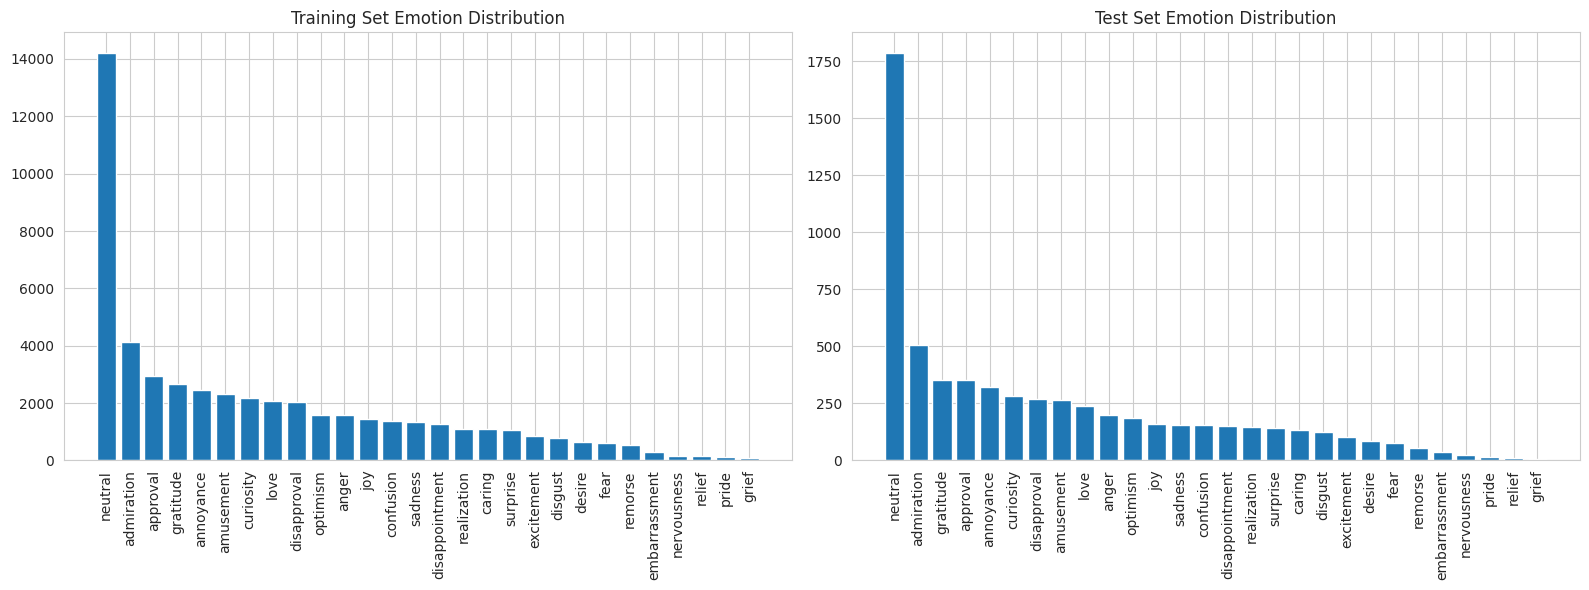

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(train_df['Emotion'], train_df['Count'])
axes[0].set_title('Training Set Emotion Distribution')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(test_df['Emotion'], test_df['Count'])
axes[1].set_title('Test Set Emotion Distribution')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig('/content/reports/class_distribution.png', dpi=300)
plt.show()


## 3. Tokenization and Preprocessing

In [ ]:
# Configuration
MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3

print(f"Model: {MODEL_NAME}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")

Model: bert-base-uncased
Max sequence length: 128
Batch size: 16
Learning rate: 2e-05
Epochs: 3


In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")


Tokenizer loaded: bert-base-uncased
Vocabulary size: 30522


In [ ]:
emotion_names = dataset['train'].features['labels'].feature.names
num_labels = len(emotion_names)

def encode_labels(example):
    vec = [0.0] * num_labels
    for lid in example["labels"]:
        vec[lid] = 1.0
    example["labels"] = vec
    return example

dataset = dataset.map(encode_labels)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
from datasets import Features, Sequence, Value

new_features = dataset["train"].features.copy()
new_features["labels"] = Sequence(Value("float32"))

dataset = dataset.cast(new_features)


Casting the dataset:   0%|          | 0/43410 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5426 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )
    tokenized["labels"] = examples["labels"]
    return tokenized

tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["text", "id"]
)

print(tokenized_datasets)
print("Tokenization complete!")
print(f"Tokenized train samples: {len(tokenized_datasets['train'])}")
print(f"Tokenized test samples: {len(tokenized_datasets['test'])}")

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})
Tokenization complete!
Tokenized train samples: 43410
Tokenized test samples: 5427


In [ ]:
sample = tokenized_datasets["train"][0]
print(type(sample["labels"][0]), sample["labels"][:5])


<class 'float'> [0.0, 0.0, 0.0, 0.0, 0.0]


## 4. Model Training

In [ ]:
# Load model
from transformers import AutoModelForSequenceClassification

num_labels = len(emotion_names)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

print(f"Model loaded: {MODEL_NAME}")
print(f"Number of parameters: {model.num_parameters():,}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-uncased
Number of parameters: 109,503,772


In [ ]:
# Define metrics computation
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

THRESHOLD = 0.5

def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids

    probs = 1 / (1 + np.exp(-logits))        # sigmoid
    preds = (probs >= THRESHOLD).astype(int)

    return {
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
        "weighted_f1": f1_score(labels, preds, average="weighted", zero_division=0),
        "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
        "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,

    eval_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    logging_steps=100,

    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    greater_is_better=True,

    warmup_steps=500,
    fp16=torch.cuda.is_available(),
    save_total_limit=2,

    report_to="tensorboard",
    seed=42,
)


print("Training arguments configured")

Training arguments configured


In [ ]:
from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],  # NOT test
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer initialized")


/tmp/ipython-input-2076743151.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer initialized


In [ ]:
# Start training
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50 + "\n")

train_result = trainer.train()

print("\n" + "="*50)
print("TRAINING COMPLETED")
print("="*50)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training runtime: {train_result.metrics['train_runtime']:.2f}s")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")


STARTING TRAINING



Step,Training Loss,Validation Loss,Micro F1,Macro F1,Weighted F1,Micro Precision,Micro Recall
500,0.158000,0.154391,0.000000,0.000000,0.000000,0.000000,0.000000
1000,0.136100,0.135858,0.077965,0.026946,0.063109,0.768328,0.041066
1500,0.117700,0.114458,0.403404,0.119629,0.315817,0.757340,0.274922
2000,0.107100,0.105098,0.483801,0.163696,0.375561,0.703560,0.368652
2500,0.102700,0.098906,0.466344,0.164890,0.375508,0.745267,0.339342
3000,0.096500,0.094053,0.506487,0.221915,0.424388,0.727193,0.388558
3500,0.088000,0.092141,0.511235,0.266496,0.443274,0.746538,0.388715
4000,0.090600,0.090518,0.526927,0.302914,0.468350,0.729086,0.412539
4500,0.088500,0.089215,0.520102,0.315295,0.467033,0.748748,0.398433
5000,0.083700,0.087410,0.552842,0.344820,0.500300,0.733541,0.443574



TRAINING COMPLETED
Training loss: 0.1071
Training runtime: 1259.52s
Training samples/second: 103.40


In [ ]:
# Save the model
trainer.save_model(CHECKPOINT_DIR)
tokenizer.save_pretrained(CHECKPOINT_DIR)

print(f"\nModel saved to {CHECKPOINT_DIR}")


Model saved to /content/drive/MyDrive/finetuning-bert/checkpoints


## 5. Model Evaluation

In [ ]:
# Evaluate on test set
print("\nEvaluating on test set...")
predictions = trainer.predict(tokenized_datasets["test"])


logits = predictions.predictions
probs = 1 / (1 + np.exp(-logits))
preds = (probs >= THRESHOLD).astype(int)
labels = predictions.label_ids.astype(int)

metrics = {
    "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
    "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
    "weighted_f1": f1_score(labels, preds, average="weighted", zero_division=0),
    "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
    "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
}

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



Evaluating on test set...



EVALUATION RESULTS
micro_f1: 0.5767
macro_f1: 0.4012
weighted_f1: 0.5399
micro_precision: 0.7190
micro_recall: 0.4814


In [ ]:
# Classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print("\n" + "="*50)
print(classification_report(labels, preds, target_names=emotion_names, zero_division=0))


CLASSIFICATION REPORT

                precision    recall  f1-score   support

    admiration       0.70      0.74      0.72       504
     amusement       0.80      0.84      0.82       264
         anger       0.61      0.38      0.47       198
     annoyance       0.56      0.07      0.12       320
      approval       0.62      0.28      0.38       351
        caring       0.60      0.30      0.40       135
     confusion       0.60      0.27      0.37       153
     curiosity       0.55      0.41      0.47       284
        desire       0.72      0.31      0.44        83
disappointment       0.88      0.05      0.09       151
   disapproval       0.51      0.25      0.34       267
       disgust       0.88      0.24      0.38       123
 embarrassment       0.67      0.05      0.10        37
    excitement       0.75      0.23      0.36       103
          fear       0.73      0.56      0.64        78
     gratitude       0.95      0.90      0.92       352
         grief       0.

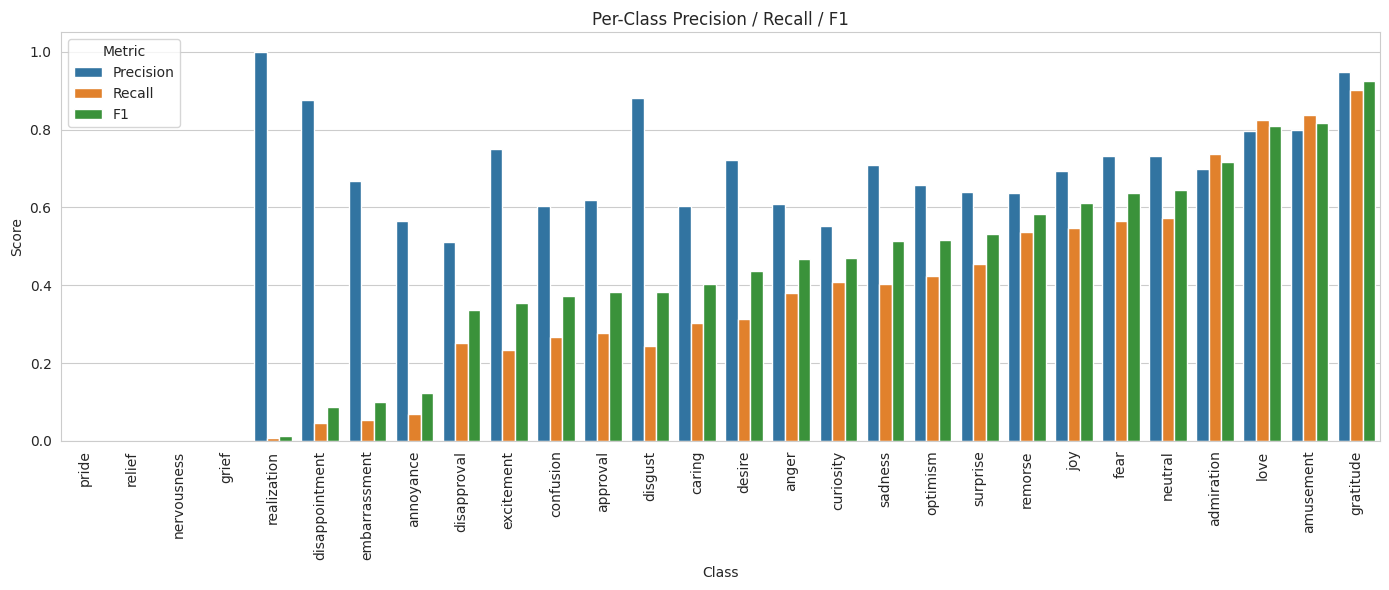

In [ ]:
report_dict = classification_report(labels, preds, target_names=emotion_names, output_dict=True, zero_division=0)

metrics_df = pd.DataFrame([
    {
        "Class": k,
        "Precision": v["precision"],
        "Recall": v["recall"],
        "F1": v["f1-score"]
    }
    for k, v in report_dict.items()
    if k in emotion_names
])

metrics_df = metrics_df.sort_values("F1")

metrics_df_melted = metrics_df.melt(id_vars="Class", var_name="Metric", value_name="Score")

plt.figure(figsize=(14, 6))
sns.barplot(data=metrics_df_melted, x="Class", y="Score", hue="Metric")
plt.xticks(rotation=90)
plt.title("Per-Class Precision / Recall / F1")
plt.tight_layout()
plt.show()


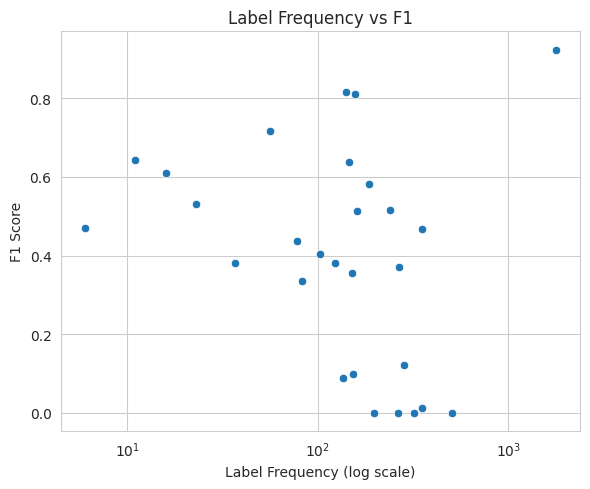

In [ ]:
label_freq = labels.sum(axis=0)

freq_df = pd.DataFrame({
    "Class": emotion_names,
    "Frequency": label_freq,
    "F1": metrics_df.set_index("Class")["F1"]
}).reset_index(drop=True)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=freq_df, x="Frequency", y="F1")
plt.xscale("log")
plt.title("Label Frequency vs F1")
plt.xlabel("Label Frequency (log scale)")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()


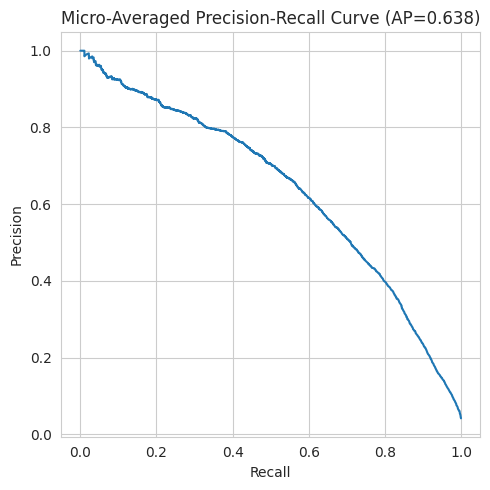

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(labels.ravel(), probs.ravel())
ap = average_precision_score(labels, probs, average="micro")

plt.figure(figsize=(5, 5))
plt.plot(recall, precision)
plt.title(f"Micro-Averaged Precision-Recall Curve (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()


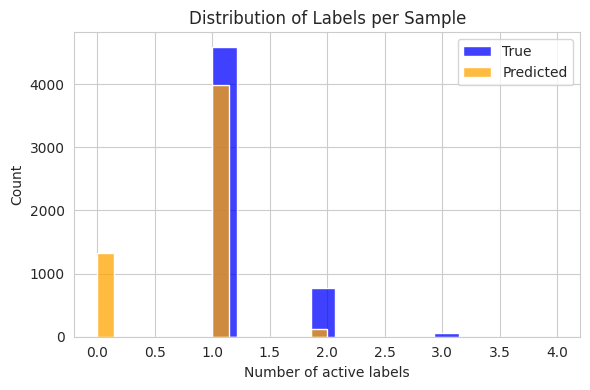

In [ ]:
true_counts = labels.sum(axis=1)
pred_counts = preds.sum(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(true_counts, color="blue", label="True", kde=False)
sns.histplot(pred_counts, color="orange", label="Predicted", kde=False)
plt.legend()
plt.title("Distribution of Labels per Sample")
plt.xlabel("Number of active labels")
plt.tight_layout()
plt.show()


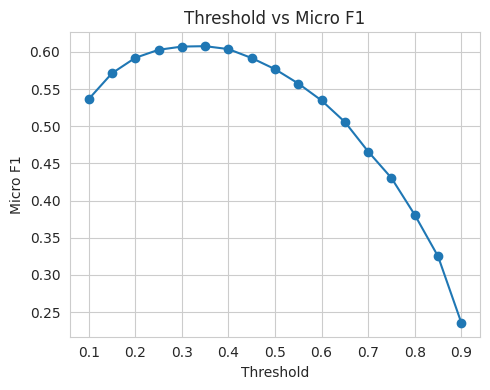

In [ ]:
thresholds = np.linspace(0.1, 0.9, 17)
f1s = []

for t in thresholds:
    p = (probs >= t).astype(int)
    f1s.append(f1_score(labels, p, average="micro", zero_division=0))

plt.figure(figsize=(5, 4))
plt.plot(thresholds, f1s, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Micro F1")
plt.title("Threshold vs Micro F1")
plt.tight_layout()
plt.show()


## 6. Inference and Predictions

In [ ]:
# Inference class
class TextClassifier:
    def __init__(self, model_path, threshold=0.3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()
        self.threshold = threshold

        # Load correct class names from model config
        self.class_names = [self.model.config.id2label[i] for i in range(self.model.config.num_labels)]

    def predict(self, text, return_probabilities=False):
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            logits = self.model(**inputs).logits
            probs = torch.sigmoid(logits)[0].cpu().numpy()

        pred_mask = probs >= self.threshold
        predicted_classes = [self.class_names[i] for i, v in enumerate(pred_mask) if v]
        confidences = {self.class_names[i]: float(probs[i]) for i in range(len(probs))}

        result = {
            "text": text,
            "predicted_classes": predicted_classes,
        }

        if return_probabilities:
            result["probabilities"] = confidences

        return result

# Load classifier
classifier = TextClassifier(CHECKPOINT_DIR)
print("Classifier loaded and ready!")

Classifier loaded and ready!


In [ ]:
# Test examples
test_texts = [
    "The stock market reached record highs today as tech companies reported strong earnings.",
    "NASA announces new mission to explore Mars with advanced rovers.",
    "The championship game was decided in overtime with a stunning goal.",
    "Political leaders met at the UN summit to discuss climate change policies."
]

print("\n" + "="*70)
print("INFERENCE EXAMPLES")
print("="*70)

for i, text in enumerate(test_texts, 1):
    print(f"\nExample {i}:")
    print(f"Text: {text}")

    result = classifier.predict(text, return_probabilities=True)

    print(f"Predicted classes: {result['predicted_classes']}")

    print("\nClass probabilities:")
    for class_name, prob in sorted(result["probabilities"].items(), key=lambda x: -x[1]):
        bar = "█" * int(prob * 50)
        print(f"  {class_name:12s} {prob:.4f} {bar}")



INFERENCE EXAMPLES

Example 1:
Text: The stock market reached record highs today as tech companies reported strong earnings.
Predicted classes: ['LABEL_0']

Class probabilities:
  LABEL_0      0.4298 █████████████████████
  LABEL_27     0.2890 ██████████████
  LABEL_4      0.1484 ███████
  LABEL_20     0.0477 ██
  LABEL_13     0.0428 ██
  LABEL_17     0.0301 █
  LABEL_22     0.0295 █
  LABEL_26     0.0159 
  LABEL_3      0.0088 
  LABEL_5      0.0082 
  LABEL_15     0.0076 
  LABEL_7      0.0076 
  LABEL_8      0.0066 
  LABEL_21     0.0064 
  LABEL_9      0.0063 
  LABEL_6      0.0051 
  LABEL_10     0.0042 
  LABEL_1      0.0041 
  LABEL_11     0.0035 
  LABEL_2      0.0033 
  LABEL_23     0.0028 
  LABEL_18     0.0019 
  LABEL_25     0.0018 
  LABEL_12     0.0018 
  LABEL_14     0.0017 
  LABEL_19     0.0015 
  LABEL_16     0.0013 
  LABEL_24     0.0007 

Example 2:
Text: NASA announces new mission to explore Mars with advanced rovers.
Predicted classes: ['LABEL_27']

Class probabi

In [ ]:
print("\n" + "="*70)
print("SAMPLE TEST SET PREDICTIONS")
print("="*70)

for i in range(5):
    idx = np.random.randint(0, len(dataset["test"]))
    example = dataset["test"][idx]
    text = example["text"]

    true_labels = [emotion_names[i] for i, v in enumerate(example["labels"]) if v > 0.5]

    result = classifier.predict(text, return_probabilities=True)
    pred_labels = result["predicted_classes"]

    print(f"\nExample {i+1}:")
    print(f"Text: {text[:150]}...")
    print(f"True labels: {true_labels}")
    print(f"Predicted labels: {pred_labels}")

    overlap = set(true_labels) & set(pred_labels)
    print(f"Overlap: {list(overlap)}")
    print(f"Any correct?: {'✓' if overlap else '✗'}")

    print("Top probabilities:")
    for cls, prob in sorted(result["probabilities"].items(), key=lambda x: -x[1])[:5]:
        print(f"  {cls:12s} {prob:.3f}")



SAMPLE TEST SET PREDICTIONS

Example 1:
Text: Binge drinking is a big problem in VN right now, unfortunately. So I wouldn't be surprised if drunkenness was the main cause of this. ...
True labels: ['approval', 'disappointment']
Predicted labels: []
Overlap: []
Any correct?: ✗
Top probabilities:
  LABEL_9      0.293
  LABEL_22     0.209
  LABEL_26     0.167
  LABEL_27     0.126
  LABEL_25     0.070

Example 2:
Text: iS thIs a MeTapHor FoR LifE?...
True labels: ['curiosity']
Predicted labels: ['LABEL_7']
Overlap: []
Any correct?: ✗
Top probabilities:
  LABEL_7      0.577
  LABEL_27     0.290
  LABEL_6      0.282
  LABEL_3      0.014
  LABEL_4      0.011

Example 3:
Text: Super unflattering. [NAME] is not overweight but this ensemble made her appear chunky....
True labels: ['disapproval']
Predicted labels: ['LABEL_0']
Overlap: []
Any correct?: ✗
Top probabilities:
  LABEL_0      0.819
  LABEL_27     0.192
  LABEL_4      0.044
  LABEL_3      0.016
  LABEL_10     0.012

Example 4:
Text: An

## 7. Save Results

In [ ]:
results_summary = {
    'Model': MODEL_NAME,
    'Dataset': 'GoEmotions',
    'Train Samples': len(dataset['train']),
    'Test Samples': len(dataset['test']),
    'Epochs': NUM_EPOCHS,
    'Batch Size': BATCH_SIZE,
    'Learning Rate': LEARNING_RATE,
    'Micro F1': metrics['micro_f1'],
    'Macro F1': metrics['macro_f1'],
    'Weighted F1': metrics['weighted_f1'],
    'Micro Precision': metrics['micro_precision'],
    'Micro Recall': metrics['micro_recall'],
}

results_df = pd.DataFrame([results_summary])
results_df.to_csv(f'{REPORTS_DIR}/training_results.csv', index=False)

print(f"Results saved to {REPORTS_DIR}/training_results.csv")
print("\nResults Summary:")
print(results_df.T)


Results saved to /content/reports/training_results.csv

Results Summary:
                                 0
Model            bert-base-uncased
Dataset                 GoEmotions
Train Samples                43410
Test Samples                  5427
Epochs                           3
Batch Size                      16
Learning Rate              0.00002
Micro F1                  0.576701
Macro F1                  0.401247
Weighted F1               0.539859
Micro Precision           0.718971
Micro Recall              0.481435


## 8. Download Model (Optional)

In [ ]:
# Zip the checkpoint for download
!zip -r /content/bert_model.zip /content/checkpoints/

from google.colab import files
# files.download('/content/bert_model.zip')  # Uncomment to download

print("Model zipped and ready for download!")
print("Uncomment the files.download() line to download the model.")